In [5]:
import os
import numpy as np
import threading as thr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [3]:
mammo_o = []
mammo_f = []
label = []
project_folder = "C:/Users/utente/Documents/CMEPDA_final_project/dataset/"
os.chdir(project_folder)
l = os.listdir()

In [4]:
def create_dataset(ls, o_img, f_img, lbl):
    for l in ls:
        if "_1_resized.pgm" in l:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(project_folder,l)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            lbl.append(1)
        elif "_2_resized.pgm" in l:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(project_folder,l)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            lbl.append(0)

In [5]:
os.chdir("C:/Users/utente/Documents/CMEPDA_final_project/")
threads = []
chunk = 6
for i in range(49):
    t = thr.Thread(target = create_dataset, args = (l[i*chunk : (i+1)*chunk], mammo_o, mammo_f, label))
    threads.append(t)
    t.start()

for i in threads:
    i.join()

In [6]:
eng.quit()

In [7]:
mammo_o = np.asarray(mammo_o, dtype = 'float32')/255.
mammo_f = np.asarray(mammo_f, dtype = 'float32')/255.
label = np.asarray(label)

In [8]:
mammo_o_4d = np.reshape(mammo_o, (147, 125, 125, 1))
print(mammo_o_4d.shape)
mammo_f_4d = np.reshape(mammo_f, (147, 64, 64, 1))
print(mammo_f_4d.shape)

(147, 125, 125, 1)
(147, 64, 64, 1)


In [11]:
def cnn_f(shape=(64, 64, 1)):
    model = Sequential([
        
        Conv2D(8, (3,3), padding = 'same', input_shape = shape),
        BatchNormalization(),
        Activation('relu'),
    
        MaxPool2D((4,4), strides = 2),
        #Dropout(0.1),
        
        
        Conv2D(15, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((4,4), strides = 2),
        #Dropout(0.1),
        
        
        Conv2D(30, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((4,4), strides = 2),
        #Dropout(0.1),
        
        Flatten(),
        
        Dense(10, activation = 'relu'),
        #Dropout(0.1),
        Dense(1, activation = 'sigmoid')        
        
    ])
    
    return model

In [12]:
model_f = cnn_f()
model_f.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 8)         80        
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 8)        32        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 8)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 31, 31, 15)        1095      
                                                                 
 batch_normalization_4 (Batc  (None, 31, 31, 15)      

In [13]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
                rotation_range = 90,
                horizontal_flip = True,
                vertical_flip = True,
                validation_split = 0.20)

aug_train_f = aug.flow(mammo_f_4d, label, batch_size = 30, subset = 'training')
aug_val_f = aug.flow(mammo_f_4d, label, batch_size = 30, subset = 'validation')

In [14]:
from tensorflow.keras.optimizers import SGD
learning_rate = 0.001
#model_o.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_f.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [15]:
checkpoint = ModelCheckpoint(
    "model-{epoch:02d}-{val_accuracy:.2f}.h5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

In [16]:
X_train_f, X_val_f, Y_train_f, Y_val_f = train_test_split(mammo_f_4d, label, test_size = 0.2, random_state = 44)
batch_size = 21
traino = model_f.fit(X_train_f, Y_train_f,
                            batch_size = batch_size,
                            epochs = 300,
                            verbose=1,
                            validation_data=(X_val_f, Y_val_f),
                            callbacks=[reduce_on_plateau])
    

Epoch 1/300
6/6 [==============================] - 2s 157ms/step - loss: 0.7456 - accuracy: 0.5897 - val_loss: 0.6887 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/300
6/6 [==============================] - 1s 94ms/step - loss: 0.6340 - accuracy: 0.6667 - val_loss: 0.6849 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 3/300
6/6 [==============================] - 1s 100ms/step - loss: 0.5200 - accuracy: 0.7778 - val_loss: 0.6801 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/300
6/6 [==============================] - 1s 97ms/step - loss: 0.4836 - accuracy: 0.7521 - val_loss: 0.6786 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 5/300
6/6 [==============================] - 1s 145ms/step - loss: 0.4508 - accuracy: 0.7778 - val_loss: 0.6811 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 6/300
6/6 [==============================] - 1s 97ms/step - loss: 0.4437 - accuracy: 0.7778 - val_loss: 0.6829 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 7/300
6/6 [==============================] - 1s 94ms/step - loss: 0.4231 

Epoch 105/300
6/6 [==============================] - 1s 90ms/step - loss: 0.2911 - accuracy: 0.9145 - val_loss: 0.6087 - val_accuracy: 0.7667 - lr: 1.0000e-11
Epoch 106/300
6/6 [==============================] - 1s 86ms/step - loss: 0.3008 - accuracy: 0.9060 - val_loss: 0.6079 - val_accuracy: 0.7667 - lr: 1.0000e-11
Epoch 107/300
6/6 [==============================] - 1s 131ms/step - loss: 0.2879 - accuracy: 0.9145 - val_loss: 0.6070 - val_accuracy: 0.7667 - lr: 1.0000e-11
Epoch 108/300
6/6 [==============================] - 1s 107ms/step - loss: 0.2937 - accuracy: 0.9145 - val_loss: 0.6065 - val_accuracy: 0.7333 - lr: 1.0000e-11
Epoch 109/300
6/6 [==============================] - 1s 104ms/step - loss: 0.2920 - accuracy: 0.9145 - val_loss: 0.6057 - val_accuracy: 0.7333 - lr: 1.0000e-11
Epoch 110/300
6/6 [==============================] - 0s 79ms/step - loss: 0.2984 - accuracy: 0.9145 - val_loss: 0.6048 - val_accuracy: 0.7333 - lr: 1.0000e-11
Epoch 111/300
6/6 [========================

Epoch 208/300
6/6 [==============================] - 0s 73ms/step - loss: 0.2895 - accuracy: 0.9145 - val_loss: 0.5993 - val_accuracy: 0.6667 - lr: 1.0000e-18
Epoch 209/300
6/6 [==============================] - 0s 74ms/step - loss: 0.2854 - accuracy: 0.9231 - val_loss: 0.5994 - val_accuracy: 0.6667 - lr: 1.0000e-18
Epoch 210/300
6/6 [==============================] - 0s 71ms/step - loss: 0.3014 - accuracy: 0.9060 - val_loss: 0.5994 - val_accuracy: 0.6667 - lr: 1.0000e-18
Epoch 211/300
6/6 [==============================] - 0s 73ms/step - loss: 0.2956 - accuracy: 0.9145 - val_loss: 0.5994 - val_accuracy: 0.6667 - lr: 1.0000e-18
Epoch 212/300
6/6 [==============================] - 0s 76ms/step - loss: 0.2868 - accuracy: 0.9145 - val_loss: 0.5993 - val_accuracy: 0.6667 - lr: 1.0000e-18
Epoch 213/300
6/6 [==============================] - 0s 74ms/step - loss: 0.2986 - accuracy: 0.9145 - val_loss: 0.5993 - val_accuracy: 0.6667 - lr: 1.0000e-18
Epoch 214/300
6/6 [===========================

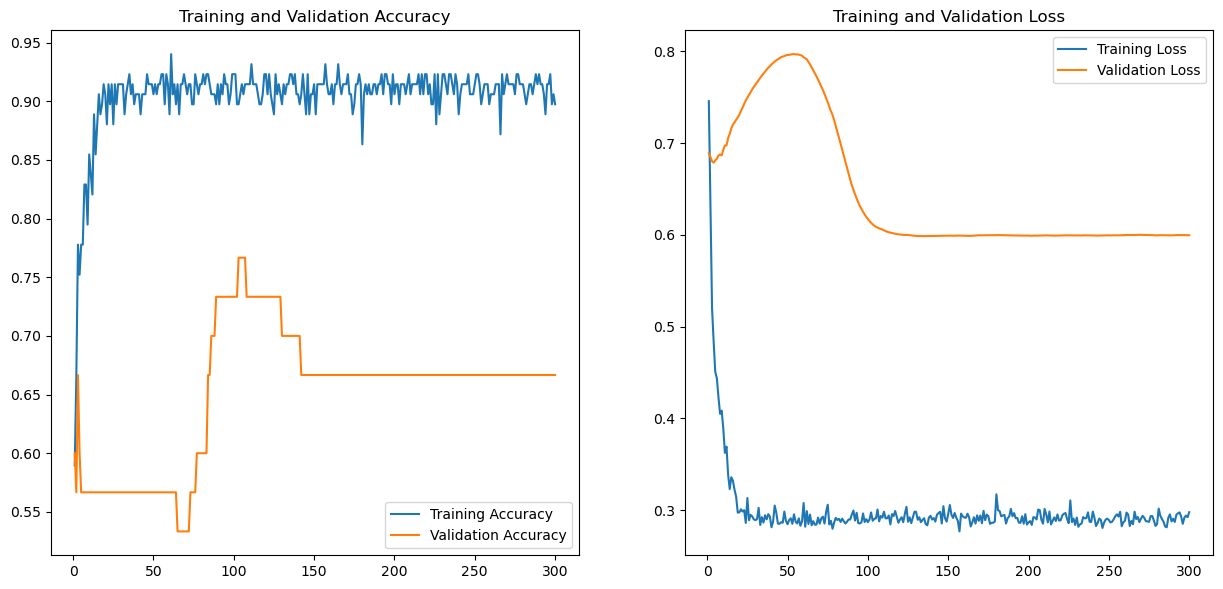

In [17]:
acc = traino.history['accuracy']
val_acc = traino.history['val_accuracy']
loss = traino.history['loss']
val_loss = traino.history['val_loss']
    
epochs_range = range(1, len(acc)+1)
    #Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
    #Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Validation accuracy: 0.667
1/1 [==============================] - 0s 254ms/step


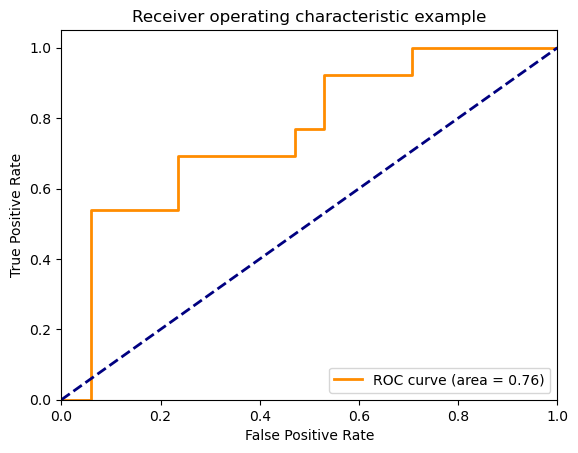

In [18]:
_, val_acc = model_f.evaluate(X_val_f, Y_val_f, verbose=0)
print('Validation accuracy: %.3f' % (val_acc))
    
    
preds = model_f.predict(X_val_f, verbose=1)

    #Compute Receiver operating characteristic (ROC)
fpr, tpr, _ = roc_curve(Y_val_f, preds)

roc_auc = auc(fpr, tpr)
   #Plot of a ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#CROSS-VALIDATION with ORIGINAL DATA (X_slice_o)

A = []
V_A = []
L = []
V_L = []
ROC = []

for i in range(3):
    X_train_o, X_val_o, Y_train_o, Y_val_o = train_test_split(mammo_o_4d, label, test_size = 0.168, random_state = 40)
    traino = model_o.fit(X_train_o, Y_train_o,
                            batch_size = 49,
                            epochs = 200,
                            verbose=1,
                            validation_data=(X_val_o, Y_val_o),
                            callbacks=[checkpoint,reduce_on_plateau])
    
    acc = traino.history['accuracy']
    val_acc = traino.history['val_accuracy']
    loss = traino.history['loss']
    val_loss = traino.history['val_loss']
    
    A.append(acc)
    V_A.append(val_acc)
    L.append(loss)
    V_L.append(val_loss)
    
    epochs_range = range(1, len(acc)+1)
    #Train and validation accuracy 
    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    #Train and validation loss 
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
    _, val_acc = model_o.evaluate(X_val_o, Y_val_o, verbose=0)
    print('Validation accuracy: %.3f' % (val_acc))
    
    
    preds = model_o.predict(X_val_o, verbose=1)

    #Compute Receiver operating characteristic (ROC)
    fpr, tpr, _ = roc_curve(Y_val_o, preds)

    roc_auc = auc(fpr, tpr)
    ROC.append(roc_auc)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
media = np.mean(ROC)
std = np.std(ROC)
print(media)
print(std)